# Stock Price Prediction using Machine Learning

This notebook demonstrates how to predict next-day stock closing prices using Linear Regression and Random Forest models with historical stock data from Yahoo Finance.

## Objectives:
- Load historical stock data using yfinance
- Preprocess time series data for machine learning
- Train Linear Regression and Random Forest models
- Evaluate model performance
- Visualize actual vs predicted prices

In [1]:
# Import essential libraries for data handling, modeling, and visualization
import yfinance as yf   # For downloading stock data (if API works)
import pandas as pd     # For working with data tables
import numpy as np      # For numerical operations
import os               # For file and directory handling

# Visualization libraries
import matplotlib.pyplot as plt   # For plotting graphs
import seaborn as sns             # For prettier plots

# Machine learning tools
from sklearn.model_selection import train_test_split  # For splitting data into train/test sets
from sklearn.linear_model import LinearRegression     # Linear regression model
from sklearn.ensemble import RandomForestRegressor    # Random forest model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # For evaluating model performance
from sklearn.preprocessing import StandardScaler      # For scaling features

# Suppress warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

# Set plot style for consistency
plt.style.use('default')                  # Use default matplotlib style
sns.set_palette("husl")                   # Set color palette for seaborn
plt.rcParams['figure.figsize'] = (12, 6)  # Set default figure size

print("All libraries imported and plotting style set!")

All libraries imported and plotting style set!


## 1. Data Collection and Exploration

We'll fetch historical stock data for multiple companies to demonstrate the prediction models.

In [2]:
# Define path to local CSV file and stock symbol
CSV_PATH = 'data/AAPL.csv'
STOCK_SYMBOL = 'AAPL'

def load_local_stock_data(filepath):
    """
    Load historical stock data from a local CSV file.
    
    Parameters:
    filepath (str): Path to the CSV file
    
    Returns:
    pandas.DataFrame: Historical stock data
    """
    try:
        # Check if the file exists at the given path
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            return None
        
        # Read the CSV file, parse dates, and set 'Date' as the index
        data = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
        
        # Check if the file was empty
        if data.empty:
            print(f"No data found in file: {filepath}")
            return None
        
        # Confirm successful data load
        print(f"Successfully loaded {len(data)} days of data from {filepath}")
        return data
    
    except Exception as e:
        # Handle any unexpected errors during file reading
        print(f"Error loading data from {filepath}: {str(e)}")
        return None

# Load data for the selected stock
stock_data = {}
data = load_local_stock_data(CSV_PATH)
if data is not None:
    stock_data[STOCK_SYMBOL] = data

# Print summary of loaded stocks
print(f"\nSuccessfully loaded data for {len(stock_data)} stock(s)")
print(f"Available stocks: {list(stock_data.keys())}")

Successfully loaded 1258 days of data from data/AAPL.csv

Successfully loaded data for 1 stock(s)
Available stocks: ['AAPL']


In [3]:
# Display sample data for the loaded stock
if stock_data:
    # Get the first stock symbol from the dictionary
    first_stock = list(stock_data.keys())[0]
    
    # Access the corresponding DataFrame
    sample_data = stock_data[first_stock]
    
    # Show the first few rows of the data
    print(f"\n ★ Sample data for {first_stock}:")
    print(sample_data.head())
    
    # Display the number of rows and columns
    print(f"\n ★ Data shape: {sample_data.shape}")
    
    # Show the date range covered by the dataset
    print(f"Date range: {sample_data.index.min().date()} to {sample_data.index.max().date()}")
    
    # Print column types and non-null counts
    print(f"\n ★ Data info:")
    print(sample_data.info())
else:
    # Handle case where no data was loaded
    print("No stock data available to display.")


 ★ Sample data for AAPL:
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-08-16  51.070000  51.790001  50.959999  51.625000  49.954624  110481600
2019-08-19  52.654999  53.182499  52.507500  52.587502  50.885971   97654400
2019-08-20  52.720001  53.337502  52.580002  52.590000  50.888390  107537200
2019-08-21  53.247501  53.412498  52.900002  53.160000  51.439960   86141600
2019-08-22  53.297501  53.610001  52.687500  53.115002  51.396420   89014800

 ★ Data shape: (1258, 6)
Date range: 2019-08-16 to 2024-08-15

 ★ Data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-08-16 to 2024-08-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   f

## 2. Data Preprocessing and Feature Engineering

We'll create features from the OHLV (Open, High, Low, Volume) data to predict the next day's closing price.

In [4]:
def create_features(data):
    """
    Create features for stock price prediction.
    
    Parameters:
    data (pandas.DataFrame): Stock data with OHLV columns
    
    Returns:
    pandas.DataFrame: Data with engineered features
    """
    df = data.copy()
    
    # Basic price movement features
    df['Price_Range'] = df['High'] - df['Low']                      # Daily high-low range
    df['Price_Change'] = df['Close'] - df['Open']                   # Net change from open to close
    df['Price_Change_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100  # Percentage change
    
    # Moving averages to capture short-term trends
    df['MA_5'] = df['Close'].rolling(window=5).mean()               # 5-day moving average
    df['MA_10'] = df['Close'].rolling(window=10).mean()             # 10-day moving average
    df['MA_20'] = df['Close'].rolling(window=20).mean()             # 20-day moving average
    
    # Relative position of current close to moving averages
    df['Close_MA5_Ratio'] = df['Close'] / df['MA_5']
    df['Close_MA10_Ratio'] = df['Close'] / df['MA_10']
    df['Close_MA20_Ratio'] = df['Close'] / df['MA_20']
    
    # Volatility indicators based on rolling standard deviation
    df['Volatility_5'] = df['Close'].rolling(window=5).std()
    df['Volatility_10'] = df['Close'].rolling(window=10).std()
    
    # Volume-based features
    df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()       # 5-day average volume
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_5']           # Current volume vs average
    
    # Lagged features to capture previous day's values
    df['Prev_Close'] = df['Close'].shift(1)
    df['Prev_Volume'] = df['Volume'].shift(1)
    df['Prev_High'] = df['High'].shift(1)
    df['Prev_Low'] = df['Low'].shift(1)
    
    # Candlestick pattern features
    df['Upper_Shadow'] = df['High'] - np.maximum(df['Open'], df['Close'])  # Wick above body
    df['Lower_Shadow'] = np.minimum(df['Open'], df['Close']) - df['Low']   # Wick below body
    df['Body_Size'] = np.abs(df['Close'] - df['Open'])                     # Size of candle body
    
    # Target variable: next day's closing price
    df['Next_Close'] = df['Close'].shift(-1)
    
    return df

# Apply feature engineering to each loaded stock
processed_data = {}
for symbol, data in stock_data.items():
    processed_data[symbol] = create_features(data)
    print(f" Created features for {symbol}: {processed_data[symbol].shape}")

# Confirm completion
print("\n Feature engineering completed!")

 Created features for AAPL: (1258, 27)

 Feature engineering completed!


In [5]:
# Display feature columns and sample data
if processed_data:
    # Select the first stock from the processed data
    sample_stock = list(processed_data.keys())[0]
    
    # Get the corresponding DataFrame with engineered features
    sample_features = processed_data[sample_stock]
    
    # Print all feature column names, excluding non-predictive ones
    print(f"\nFeature columns for {sample_stock}:")
    feature_cols = [col for col in sample_features.columns if col not in ['Dividends', 'Stock Splits']]
    for i, col in enumerate(feature_cols, 1):
        print(f"{i:2d}. {col}")
    
    # Define a subset of columns to display for quick inspection
    display_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                    'Price_Range', 'MA_5', 'Volatility_5', 'Next_Close']
    
    # Filter out any columns that might be missing
    available_cols = [col for col in display_cols if col in sample_features.columns]
    
    # Show the first 10 rows of selected columns
    print(f"\nSample processed data for {sample_stock}:")
    print(sample_features[available_cols].head(10))
else:
    # Handle case where no processed data is available
    print("No processed data available.")


Feature columns for AAPL:
 1. Open
 2. High
 3. Low
 4. Close
 5. Adj Close
 6. Volume
 7. Price_Range
 8. Price_Change
 9. Price_Change_Pct
10. MA_5
11. MA_10
12. MA_20
13. Close_MA5_Ratio
14. Close_MA10_Ratio
15. Close_MA20_Ratio
16. Volatility_5
17. Volatility_10
18. Volume_MA_5
19. Volume_Ratio
20. Prev_Close
21. Prev_Volume
22. Prev_High
23. Prev_Low
24. Upper_Shadow
25. Lower_Shadow
26. Body_Size
27. Next_Close

Sample processed data for AAPL:
                 Open       High        Low      Close     Volume  \
Date                                                                
2019-08-16  51.070000  51.790001  50.959999  51.625000  110481600   
2019-08-19  52.654999  53.182499  52.507500  52.587502   97654400   
2019-08-20  52.720001  53.337502  52.580002  52.590000  107537200   
2019-08-21  53.247501  53.412498  52.900002  53.160000   86141600   
2019-08-22  53.297501  53.610001  52.687500  53.115002   89014800   
2019-08-23  52.357498  53.012501  50.250000  50.660000  187272

## 3. Model Training and Evaluation

We'll train Linear Regression and Random Forest models for each stock and evaluate their performance.

In [6]:
# Prepare model data
def prepare_model_data(data, test_size=0.2):
    # Remove rows with missing values
    clean_data = data.dropna()
    
    # Check if any data remains after cleaning
    if len(clean_data) == 0:
        print("No clean data available after removing NaN values")
        return None, None, None, None, None, None
    
    # Define which columns to exclude from features
    exclude_cols = ['Next_Close', 'Dividends', 'Stock Splits']
    
    # Select feature columns
    feature_cols = [col for col in clean_data.columns if col not in exclude_cols]
    
    # Define input features (X) and target variable (y)
    X = clean_data[feature_cols]
    y = clean_data['Next_Close']
    
    # Split data chronologically into training and testing sets
    split_idx = int(len(clean_data) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Scale features to standardize input values
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, scaler

# Evaluation function
def evaluate_model(y_true, y_pred, model_name="Model"):
    # Calculate common regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Store metrics in a dictionary
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    }
    
    # Print performance summary
    print(f"\n{model_name} Performance:")
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")
    
    return metrics

# Train models
model_results = {}

# Loop through each stock and train models
for symbol in processed_data.keys():
    print(f"\n{'='*50}")
    print(f"Training models for {symbol}")
    print(f"{'='*50}")
    
    # Prepare data for modeling
    X_train, X_test, y_train, y_test, features, scaler = prepare_model_data(processed_data[symbol])
    
    # Skip if data preparation failed
    if X_train is None:
        print(f"Skipping {symbol} due to data preparation issues")
        continue
    
    # Show shapes of training and testing sets
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    # Initialize models
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
    # Train models on training data
    lr_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    
    # Generate predictions on test data
    lr_pred = lr_model.predict(X_test)
    rf_pred = rf_model.predict(X_test)
    
    # Evaluate model performance
    lr_metrics = evaluate_model(y_test, lr_pred, "Linear Regression")
    rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")
    
    # Store results for later analysis
    model_results[symbol] = {
        'models': {'lr': lr_model, 'rf': rf_model},
        'predictions': {'lr': lr_pred, 'rf': rf_pred},
        'actual': y_test,
        'metrics': {'lr': lr_metrics, 'rf': rf_metrics},
        'features': features,
        'scaler': scaler,
        'test_dates': y_test.index
    }

# Confirm completion of model training
print(f"\nModel training completed for {len(model_results)} stocks.")


Training models for AAPL
Training data shape: (990, 26)
Testing data shape: (248, 26)

Linear Regression Performance:
Mean Absolute Error (MAE): $2.04
Root Mean Square Error (RMSE): $2.82
R-squared (R²): 0.9718

Random Forest Performance:
Mean Absolute Error (MAE): $6.66
Root Mean Square Error (RMSE): $12.14
R-squared (R²): 0.4777

Model training completed for 1 stocks.


## 4. Results Visualization

Let's visualize the actual vs predicted prices for both models.

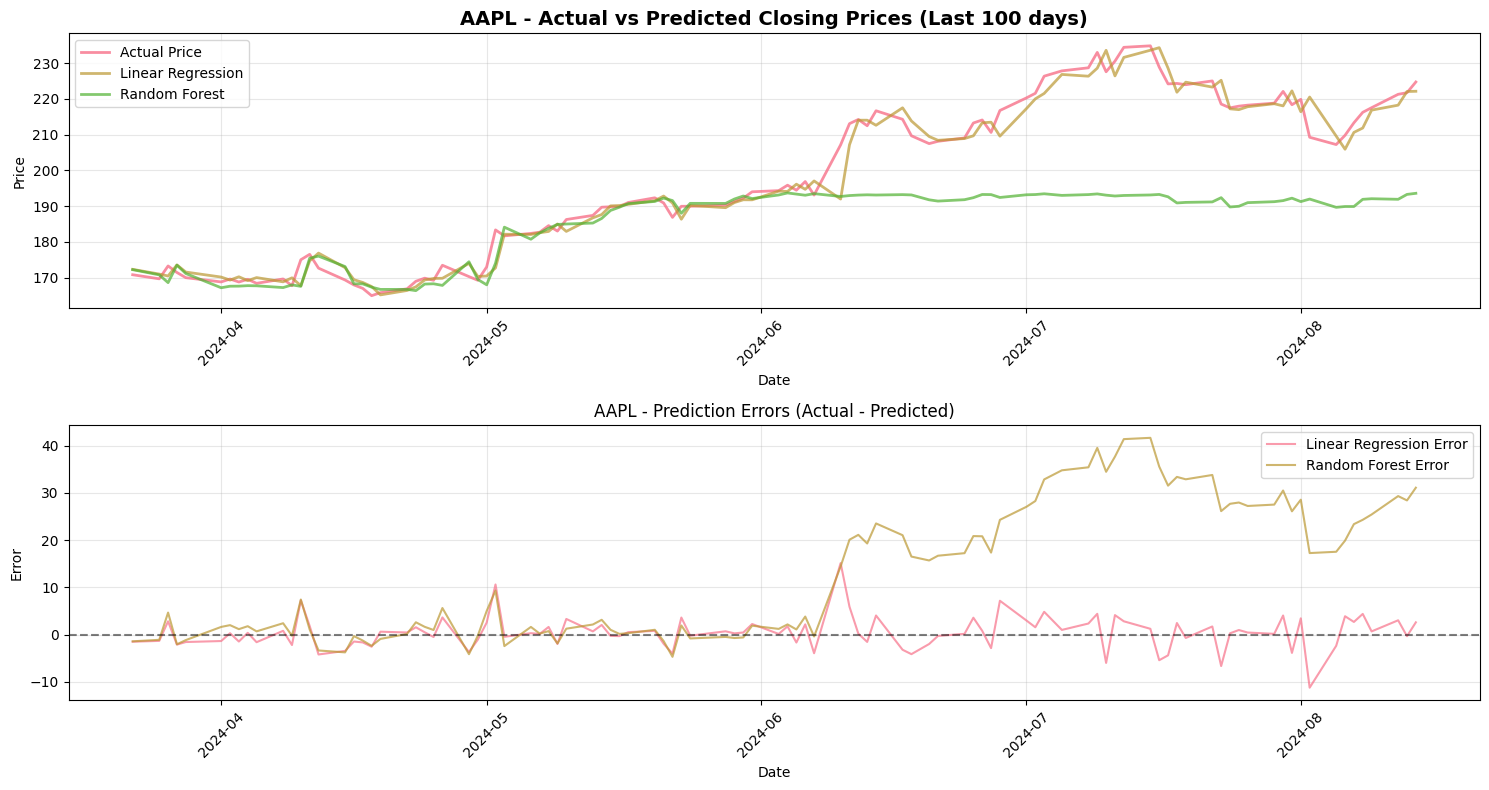

In [7]:
def plot_predictions(symbol, results, days_to_show=100):
    """
    Plot actual vs predicted prices for a stock.
    
    Parameters:
    symbol (str): Stock symbol
    results (dict): Model results for the stock
    days_to_show (int): Number of recent days to display
    """
    # Check if required data is available
    if not results or 'actual' not in results or 'predictions' not in results:
        print(f"Skipping plot for {symbol}: incomplete results")
        return
    
    # Extract actual prices, predictions, and dates
    actual = results['actual']
    lr_pred = results['predictions'].get('lr')
    rf_pred = results['predictions'].get('rf')
    dates = results.get('test_dates')
    
    # Validate that all components are present
    if actual is None or lr_pred is None or rf_pred is None or dates is None:
        print(f"Skipping plot for {symbol}: missing data")
        return
    
    # Limit the plot to the most recent 'days_to_show' entries
    if len(actual) > days_to_show:
        actual = actual[-days_to_show:]
        lr_pred = lr_pred[-days_to_show:]
        rf_pred = rf_pred[-days_to_show:]
        dates = dates[-days_to_show:]
    
    plt.figure(figsize=(15, 8))
    
    # Plot actual vs predicted closing prices
    plt.subplot(2, 1, 1)
    plt.plot(dates, actual, label='Actual Price', linewidth=2, alpha=0.8)
    plt.plot(dates, lr_pred, label='Linear Regression', linewidth=2, alpha=0.7)
    plt.plot(dates, rf_pred, label='Random Forest', linewidth=2, alpha=0.7)
    plt.title(f'{symbol} - Actual vs Predicted Closing Prices (Last {len(actual)} days)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Plot prediction errors (difference between actual and predicted)
    plt.subplot(2, 1, 2)
    lr_errors = actual - lr_pred
    rf_errors = actual - rf_pred
    plt.plot(dates, lr_errors, label='Linear Regression Error', alpha=0.7)
    plt.plot(dates, rf_errors, label='Random Forest Error', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title(f'{symbol} - Prediction Errors (Actual - Predicted)', fontsize=12)
    plt.xlabel('Date')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Generate prediction plots for each stock
for symbol, results in model_results.items():
    plot_predictions(symbol, results)

## 5. Model Performance Comparison

Model Performance Summary:
Stock             Model    MAE    RMSE     R²
 AAPL Linear Regression 2.0440  2.8243 0.9718
 AAPL     Random Forest 6.6552 12.1447 0.4777


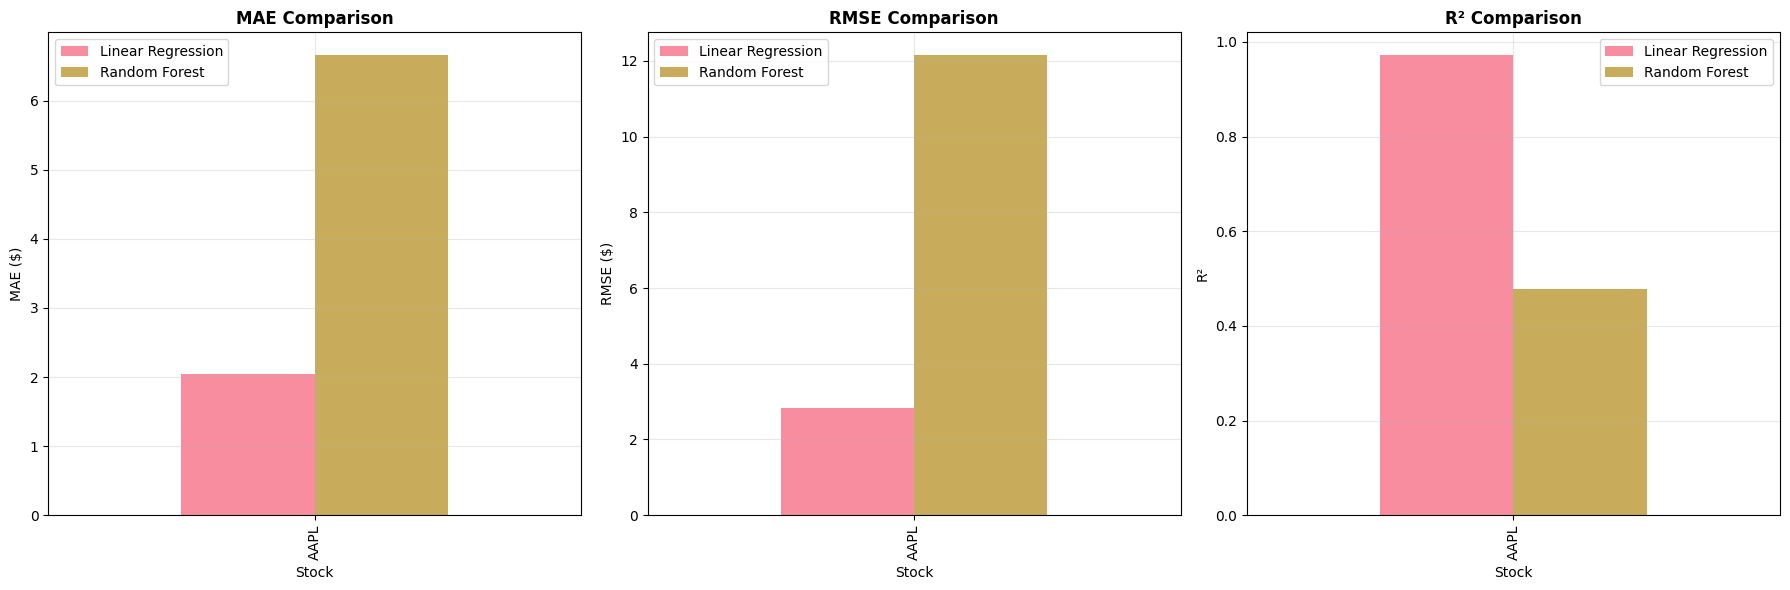

In [8]:
def create_performance_summary(model_results):
    """
    Create a summary of model performance across all stocks.
    
    Parameters:
    model_results (dict): Dictionary containing model evaluation results
    
    Returns:
    pandas.DataFrame: Summary of performance metrics
    """
    summary_data = []
    
    # Loop through each stock's results
    for symbol, results in model_results.items():
        # Skip if metrics are missing
        if 'metrics' not in results:
            continue
        
        # Get evaluation metrics for both models
        lr_metrics = results['metrics'].get('lr')
        rf_metrics = results['metrics'].get('rf')
        
        # Add metrics to summary if both models are available
        if lr_metrics and rf_metrics:
            summary_data.extend([
                [symbol, 'Linear Regression', lr_metrics['MAE'], lr_metrics['RMSE'], lr_metrics['R²']],
                [symbol, 'Random Forest', rf_metrics['MAE'], rf_metrics['RMSE'], rf_metrics['R²']]
            ])
    
    # Convert summary list to a DataFrame
    summary_df = pd.DataFrame(summary_data, columns=['Stock', 'Model', 'MAE', 'RMSE', 'R²'])
    return summary_df

# Generate and display performance summary
performance_summary = create_performance_summary(model_results)

# Check if summary contains any data
if not performance_summary.empty:
    print("Model Performance Summary:")
    print("=" * 60)
    
    # Print summary table with formatted numbers
    print(performance_summary.to_string(index=False, float_format='%.4f'))

    # Create subplots for each metric
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    metrics = ['MAE', 'RMSE', 'R²']

    # Plot bar charts comparing models for each metric
    for i, metric in enumerate(metrics):
        pivot_data = performance_summary.pivot(index='Stock', columns='Model', values=metric)
        pivot_data.plot(kind='bar', ax=axes[i], alpha=0.8)
        axes[i].set_title(f'{metric} Comparison', fontweight='bold')
        axes[i].set_xlabel('Stock')
        axes[i].set_ylabel(metric)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

        # Add dollar sign to error metrics
        if metric != 'R²':
            axes[i].set_ylabel(f'{metric} ($)')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
else:
    # Handle case where no performance data is available
    print("No performance data available to summarize.")

## 6. Feature Importance Analysis

Let's analyze which features are most important for the Random Forest model.


Feature Importance Analysis for AAPL:


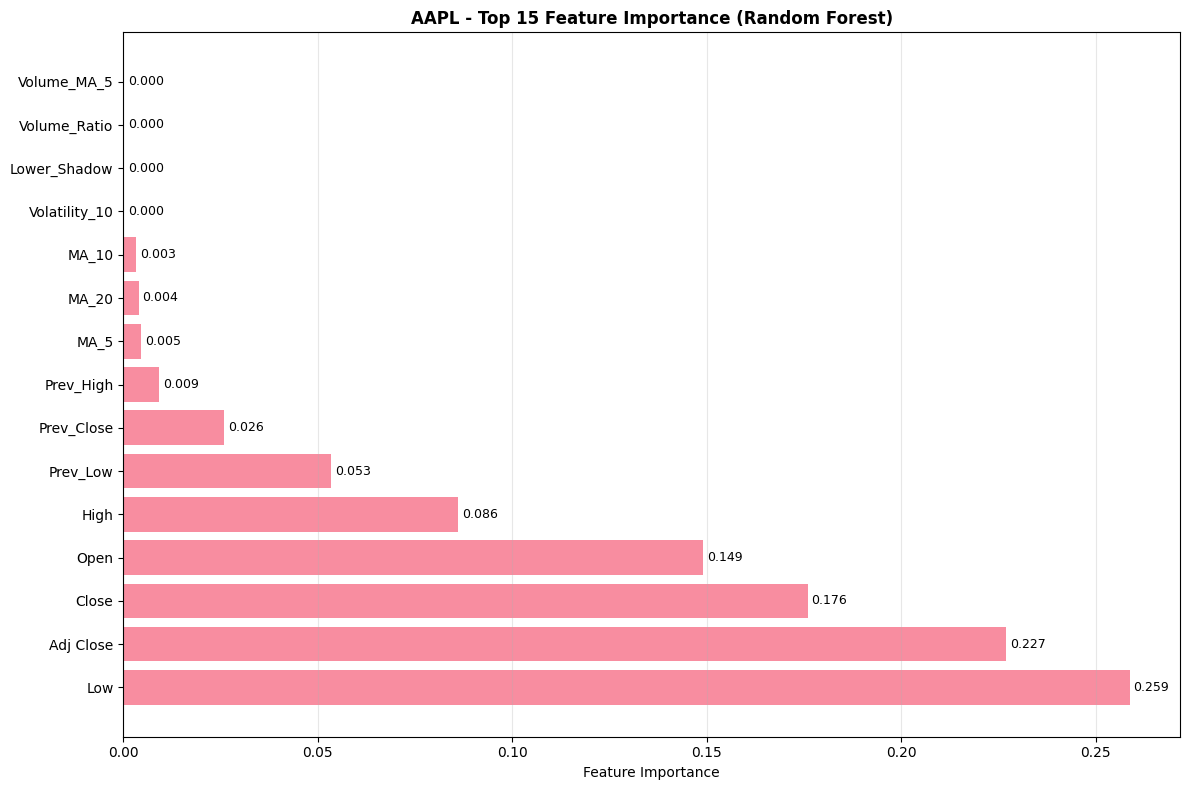


Top 10 Most Important Features for AAPL:
   feature  importance
       Low      0.2588
 Adj Close      0.2270
     Close      0.1760
      Open      0.1490
      High      0.0860
  Prev_Low      0.0535
Prev_Close      0.0259
 Prev_High      0.0093
      MA_5      0.0046
     MA_20      0.0039


In [9]:
def plot_feature_importance(symbol, results, top_n=15):
    """
    Plot feature importance for Random Forest model.
    
    Parameters:
    symbol (str): Stock symbol
    results (dict): Model results
    top_n (int): Number of top features to show
    
    Returns:
    pandas.DataFrame: Sorted feature importance values
    """
    # Check if Random Forest model is available
    if 'models' not in results or 'rf' not in results['models']:
        print(f"Skipping {symbol}: Random Forest model not found")
        return pd.DataFrame()
    
    # Retrieve model and feature names
    rf_model = results['models']['rf']
    features = results.get('features')
    
    # Validate model and feature list
    if rf_model is None or features is None:
        print(f"Skipping {symbol}: Missing model or feature names")
        return pd.DataFrame()
    
    # Extract feature importance values from the model
    importance = rf_model.feature_importances_
    
    # Create a DataFrame with feature names and importance scores
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot the top N most important features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(top_n)
    plt.barh(range(len(top_features)), top_features['importance'], alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'{symbol} - Top {top_n} Feature Importance (Random Forest)', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Annotate bars with exact importance values
    for i, (idx, row) in enumerate(top_features.iterrows()):
        plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
                 va='center', fontsize=9)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Analyze feature importance for each stock
for symbol, results in model_results.items():
    print(f"\nFeature Importance Analysis for {symbol}:")
    
    # Generate and display feature importance plot
    importance_df = plot_feature_importance(symbol, results)
    
    # Print top 10 features if available
    if not importance_df.empty:
        print(f"\nTop 10 Most Important Features for {symbol}:")
        print(importance_df.head(10).to_string(index=False, float_format='%.4f'))
    else:
        print("No feature importance data available.")

## 7. Next-Day Prediction Example

Let's make actual next-day predictions using the most recent data.

Next-Day Closing Price Predictions:

AAPL (2024-08-15):
Current Price: $224.72
Linear Regression Prediction: $222.12
  Change: $-2.60 (-1.16%)
Random Forest Prediction: $193.60
  Change: $-31.12 (-13.85%)
----------------------------------------


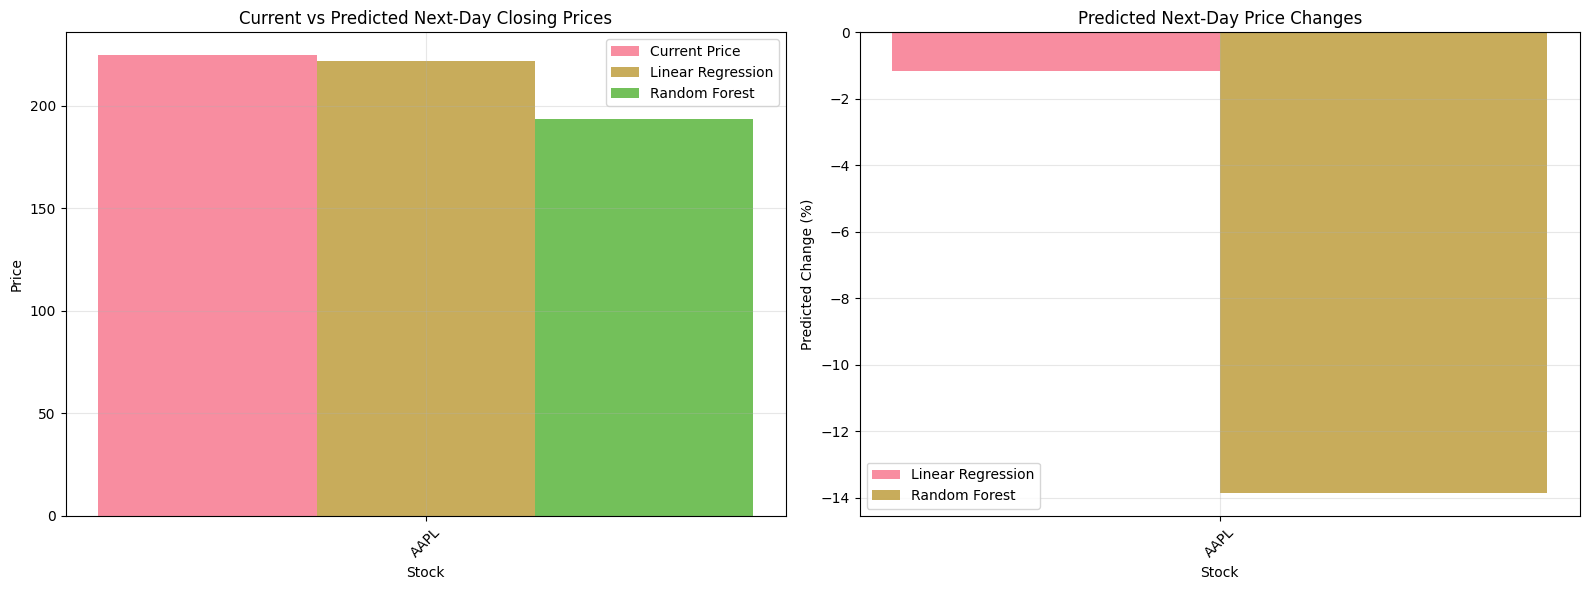

In [10]:
def make_next_day_prediction(symbol, model_data, stock_data, processed_data):
    """
    Make next-day closing price prediction using the latest data.
    
    Parameters:
    symbol (str): Stock symbol
    model_data (dict): Trained model data
    stock_data (dict): Original stock data
    processed_data (dict): Feature-engineered data
    
    Returns:
    dict: Predictions from both models
    """
    # Check if required data is available
    if symbol not in processed_data or symbol not in stock_data:
        print(f"Skipping {symbol}: missing data")
        return None
    
    # Get the most recent row of processed data
    latest_data = processed_data[symbol].dropna().iloc[-1:]
    
    # Skip if no valid data is available
    if latest_data.empty:
        print(f"No recent data available for {symbol}")
        return None
    
    # Retrieve model components
    features = model_data.get('features')
    scaler = model_data.get('scaler')
    models = model_data.get('models')
    
    # Validate model components
    if not features or not scaler or not models:
        print(f"Skipping {symbol}: model components missing")
        return None
    
    # Prepare input for prediction
    X_latest = latest_data[features]
    X_scaled = scaler.transform(X_latest)
    
    # Generate predictions using both models
    lr_pred = models['lr'].predict(X_scaled)[0]
    rf_pred = models['rf'].predict(X_scaled)[0]
    
    # Get current closing price and date
    current_price = stock_data[symbol]['Close'].iloc[-1]
    latest_date = pd.to_datetime(stock_data[symbol].index[-1]).strftime('%Y-%m-%d')
    
    # Return prediction details and changes
    return {
        'current_price': current_price,
        'latest_date': latest_date,
        'lr_prediction': lr_pred,
        'rf_prediction': rf_pred,
        'lr_change': lr_pred - current_price,
        'rf_change': rf_pred - current_price,
        'lr_change_pct': ((lr_pred - current_price) / current_price) * 100,
        'rf_change_pct': ((rf_pred - current_price) / current_price) * 100
    }

# Generate predictions
print("Next-Day Closing Price Predictions:")
print("=" * 80)

next_day_predictions = {}

# Loop through each stock and generate predictions
for symbol in model_results.keys():
    prediction = make_next_day_prediction(symbol, model_results[symbol], stock_data, processed_data)
    
    # Display prediction results if available
    if prediction:
        next_day_predictions[symbol] = prediction
        print(f"\n{symbol} ({prediction['latest_date']}):")
        print(f"Current Price: ${prediction['current_price']:.2f}")
        print(f"Linear Regression Prediction: ${prediction['lr_prediction']:.2f}")
        print(f"  Change: ${prediction['lr_change']:+.2f} ({prediction['lr_change_pct']:+.2f}%)")
        print(f"Random Forest Prediction: ${prediction['rf_prediction']:.2f}")
        print(f"  Change: ${prediction['rf_change']:+.2f} ({prediction['rf_change_pct']:+.2f}%)")
        print("-" * 40)

# Visualize predictions if available
if next_day_predictions:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Prepare data for plotting
    stocks = list(next_day_predictions.keys())
    current_prices = [next_day_predictions[s]['current_price'] for s in stocks]
    lr_preds = [next_day_predictions[s]['lr_prediction'] for s in stocks]
    rf_preds = [next_day_predictions[s]['rf_prediction'] for s in stocks]
    
    x = np.arange(len(stocks))
    width = 0.25
    
    # Plot current vs predicted prices
    ax1.bar(x - width, current_prices, width, label='Current Price', alpha=0.8)
    ax1.bar(x, lr_preds, width, label='Linear Regression', alpha=0.8)
    ax1.bar(x + width, rf_preds, width, label='Random Forest', alpha=0.8)
    ax1.set_xlabel('Stock')
    ax1.set_ylabel('Price')
    ax1.set_title('Current vs Predicted Next-Day Closing Prices')
    ax1.set_xticks(x)
    ax1.set_xticklabels(stocks, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot predicted percentage changes
    lr_changes = [next_day_predictions[s]['lr_change_pct'] for s in stocks]
    rf_changes = [next_day_predictions[s]['rf_change_pct'] for s in stocks]
    
    ax2.bar(x - width/2, lr_changes, width, label='Linear Regression', alpha=0.8)
    ax2.bar(x + width/2, rf_changes, width, label='Random Forest', alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_xlabel('Stock')
    ax2.set_ylabel('Predicted Change (%)')
    ax2.set_title('Predicted Next-Day Price Changes')
    ax2.set_xticks(x)
    ax2.set_xticklabels(stocks, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

## 8. Model Insights and Conclusions

In [11]:
print("Stock Price Prediction Analysis - Key Insights:")
print("=" * 60)

# Check that all required data is available
if model_results and stock_data and processed_data:
    try:
        # Calculate average performance metrics across all stocks
        avg_lr_r2 = np.mean([results['metrics']['lr']['R²'] for results in model_results.values()])
        avg_rf_r2 = np.mean([results['metrics']['rf']['R²'] for results in model_results.values()])
        avg_lr_mae = np.mean([results['metrics']['lr']['MAE'] for results in model_results.values()])
        avg_rf_mae = np.mean([results['metrics']['rf']['MAE'] for results in model_results.values()])
        
        # Display model performance summary
        print(f"\n1. Model Performance:")
        print(f"   • Average Linear Regression R²: {avg_lr_r2:.4f}")
        print(f"   • Average Random Forest R²: {avg_rf_r2:.4f}")
        print(f"   • Average Linear Regression MAE: ${avg_lr_mae:.2f}")
        print(f"   • Average Random Forest MAE: ${avg_rf_mae:.2f}")
        
        # Identify which model performed better overall
        better_model = "Random Forest" if avg_rf_r2 > avg_lr_r2 else "Linear Regression"
        print(f"   • {better_model} performs better on average")
        
        # Summarize data coverage and feature usage
        total_days = sum([len(data) for data in stock_data.values()])
        avg_days = total_days // len(stock_data)
        sample_key = next(iter(processed_data))
        feature_count = len(processed_data[sample_key].columns) - 1  # Exclude target
        
        print(f"\n2. Data Insights:")
        print(f"   • Analyzed {len(stock_data)} stocks over ~{avg_days} trading days each")
        print(f"   • Used {feature_count} engineered features")
        
        # Highlight the role of different feature groups
        print(f"\n3. Feature Engineering Impact:")
        print(f"   • Moving averages and ratios provide trend information")
        print(f"   • Volatility measures help capture market uncertainty")
        print(f"   • Volume indicators reflect trading activity patterns")
        print(f"   • Technical indicators (shadows, body size) capture price action")
        
        # Discuss limitations of the modeling approach
        print(f"\n4. Model Limitations:")
        print(f"   • Stock prices are inherently noisy and influenced by many external factors")
        print(f"   • Models may struggle during high volatility periods or market disruptions")
        print(f"   • Past performance doesn't guarantee future results")
        print(f"   • External events (news, earnings, market sentiment) are not captured")
        
        # Offer suggestions for improving future predictions
        print(f"\n5. Recommendations:")
        print(f"   • Use ensemble of multiple models for more robust predictions")
        print(f"   • Incorporate additional features like market sentiment, economic indicators")
        print(f"   • Consider longer prediction horizons with confidence intervals")
        print(f"   • Regular model retraining as market conditions change")
        print(f"   • Always combine with fundamental analysis for investment decisions")
        
    except Exception as e:
        # Handle any errors during summary generation
        print(f"Error during summary generation: {e}")

# Final summary messages
print("\n" + "=" * 60)
print("Analysis completed successfully!")
print(f"Next-day predictions generated for {len(next_day_predictions)} stocks.")
print("Remember: These are statistical predictions for educational purposes.")
print("Always consult with financial advisors for investment decisions.")

Stock Price Prediction Analysis - Key Insights:

1. Model Performance:
   • Average Linear Regression R²: 0.9718
   • Average Random Forest R²: 0.4777
   • Average Linear Regression MAE: $2.04
   • Average Random Forest MAE: $6.66
   • Linear Regression performs better on average

2. Data Insights:
   • Analyzed 1 stocks over ~1258 trading days each
   • Used 26 engineered features

3. Feature Engineering Impact:
   • Moving averages and ratios provide trend information
   • Volatility measures help capture market uncertainty
   • Volume indicators reflect trading activity patterns
   • Technical indicators (shadows, body size) capture price action

4. Model Limitations:
   • Stock prices are inherently noisy and influenced by many external factors
   • Models may struggle during high volatility periods or market disruptions
   • Past performance doesn't guarantee future results
   • External events (news, earnings, market sentiment) are not captured

5. Recommendations:
   • Use ensem